# Project 5: Vehicle Detection And Tracking - Deep Learning Method

In [1]:
# Load the required packages
import numpy as np
import cv2
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from keras.preprocessing.image import img_to_array

import dnmodel_def

%matplotlib inline


Using TensorFlow backend.


In [2]:
# Variables used in functions

hot_windows_list = []
sdc_model = None


Defining utility functions

In [3]:
# Function to draw grids over predictions
def draw_grids(img, result):

    windows = []
    xx, yy = np.meshgrid(np.arange(result.shape[3]),np.arange(result.shape[2]))
    x = (xx[result[0,0,:,:]>0.99])
    y = (yy[result[0,0,:,:]>0.99])
    
    for i,j in zip(x,y):
        windows.append(((i*8,j*8), (i*8+64,j*8+64)))
        cv2.rectangle(img, (i*8,j*8), (i*8+64,j*8+64), (0,0,255), 5)

    return img, windows 


# This functions creates a heatmap
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap


# Function to apply thresholds to the heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Function to draw final bounding boxes based on thresholded heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


In [4]:
# Define and load trained model
# Note that input shape is 'None'. Images need not be resized and the model accepts images of any size

# Lower initial convolutional layers are loaded with yolo_tiny pre-trained weights and trainable is set to False
# Higher layers are trained with Udacity data
sdc_model = dnmodel_def.yolo_model(input_shape=(3,None,None))
sdc_model.load_weights('model_folder/model.h5')


Testing... test_images/test6.jpg


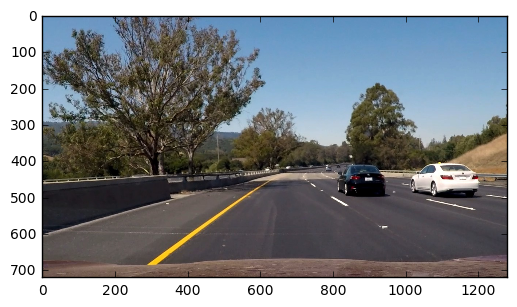

In [5]:
# Load the image to be tested
path = 'test_images/test6.jpg'
image = mpimg.imread(path)
print("Testing...", path)
plt.imshow(image)


In [6]:
# Copy the image to finally overlay tight bound boxes
draw_image = np.copy(image)

# Change the image format as required for further processing
image = img_to_array(image)


In [7]:
# Predict for the image using the trained model
predict = sdc_model.predict(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))


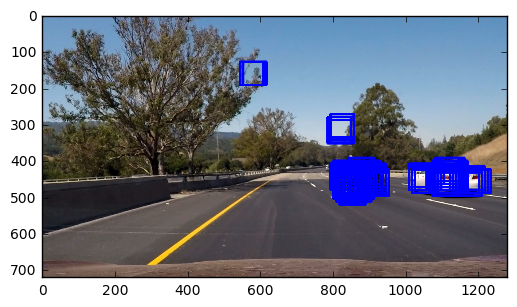

In [8]:
# Overlay meshgrids over identified vehicles
hot_windows = []
m = len(hot_windows_list)

heat_grid, grids = draw_grids(np.copy(draw_image) ,predict)
plt.imshow(heat_grid)


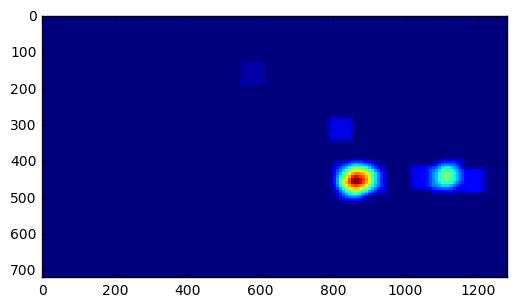

In [9]:
# Create heatmap
hot_windows.extend(grids)

heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    
heat = add_heat(heat,hot_windows)
plt.imshow(heat)


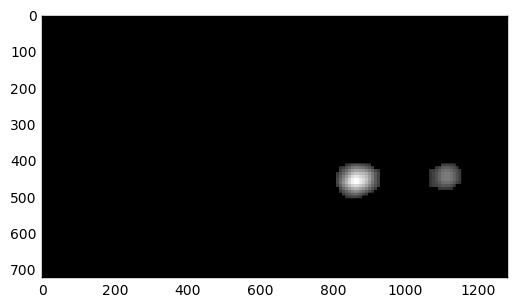

In [10]:
# Apply threshold to help remove false positives
heatmap_thresh = 10

heat = apply_threshold(heat, heatmap_thresh)
plt.imshow(heat, 'gray')


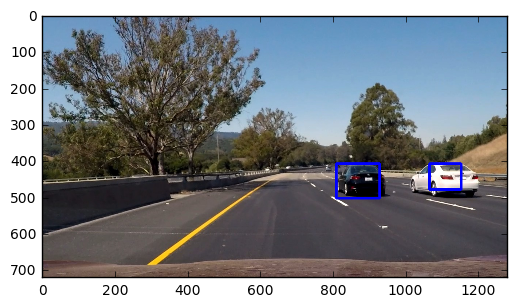

In [11]:
# Create augmented image - final bounding boxes based on thresholded heatmap

heat_clip = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heat_clip)    

draw_labeled = draw_labeled_bboxes(draw_image, labels)
plt.imshow(draw_labeled)


In [27]:
heatmap_thresh = 180

# Pipeline to process video
def process(image):
    
#    global sdc_model
    global hot_windows_list
    
    draw_image = np.copy(image)
    image = img_to_array(image)
 
    predict = sdc_model.predict(image.reshape(1,image.shape[0],image.shape[1],image.shape[2]))
    
    hot_windows = []
    m = len(hot_windows_list)

    heat_grid, grids = draw_grids(np.copy(draw_image) ,predict)
    #plt.imshow(heat_grid)

    hot_windows.extend(grids)

    if (m >= 10):
        hot_windows_list.pop(0)
    hw_new = np.copy(hot_windows)
    hot_windows_list.append(hw_new)

    for i in range(m-1):
        hw_old = np.copy(hot_windows_list[i])
        hot_windows.extend(hw_old)    
    
    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)
    
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heatmap_thresh)

    # Visualize the heatmap when displaying    
    heat_clip = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heat_clip)    

    # Return augmented image
    draw_labeled = draw_labeled_bboxes(draw_image, labels)

    # Return augmented image
    return draw_labeled


In [28]:
# Process the video
# Input video is the out from P4 project

white_output = 'dn_out.mp4'
clip1 = VideoFileClip("p4project_video.mp4")
#clip1 = VideoFileClip('p4project_video.mp4').subclip(25,40) # subclip = only specified span of video
white_clip = clip1.fl_image(process) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video dn_out.mp4
[MoviePy] Writing video dn_out.mp4


100%|█████████▉| 1260/1261 [14:06<00:00,  1.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: dn_out.mp4 

